# Predictive Model for Moose Locations in Maine
## 1. Preparing the data
Loaded 1136 observations
Converting to GeoDataFrame...
Created GeoDataFrame with 1136 points
Creating simplified Maine boundary...
Created simplified Maine boundary
Generating 1136 random points as negative examples...
Combined dataset has 2272 points
Positive examples (actual moose observations): 1136
Negative examples (random locations): 1136
Using coordinates and month as features

## 2. Training the model

## 3. Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       334
           1       1.00      0.99      1.00       348

    accuracy                           1.00       682
   macro avg       1.00      1.00      1.00       682
weighted avg       1.00      1.00      1.00       682


Confusion Matrix:
[[334   0]
 [  2 346]]

Feature Importance:
  Feature  Importance
2   month    0.731799
0       x    0.150615
1       y 

/Users/jessicachace/anaconda3/envs/inat-env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jessicachace/anaconda3/envs/inat-env/lib/python3.10/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


Prediction map saved as 'moose_prediction_map.png'


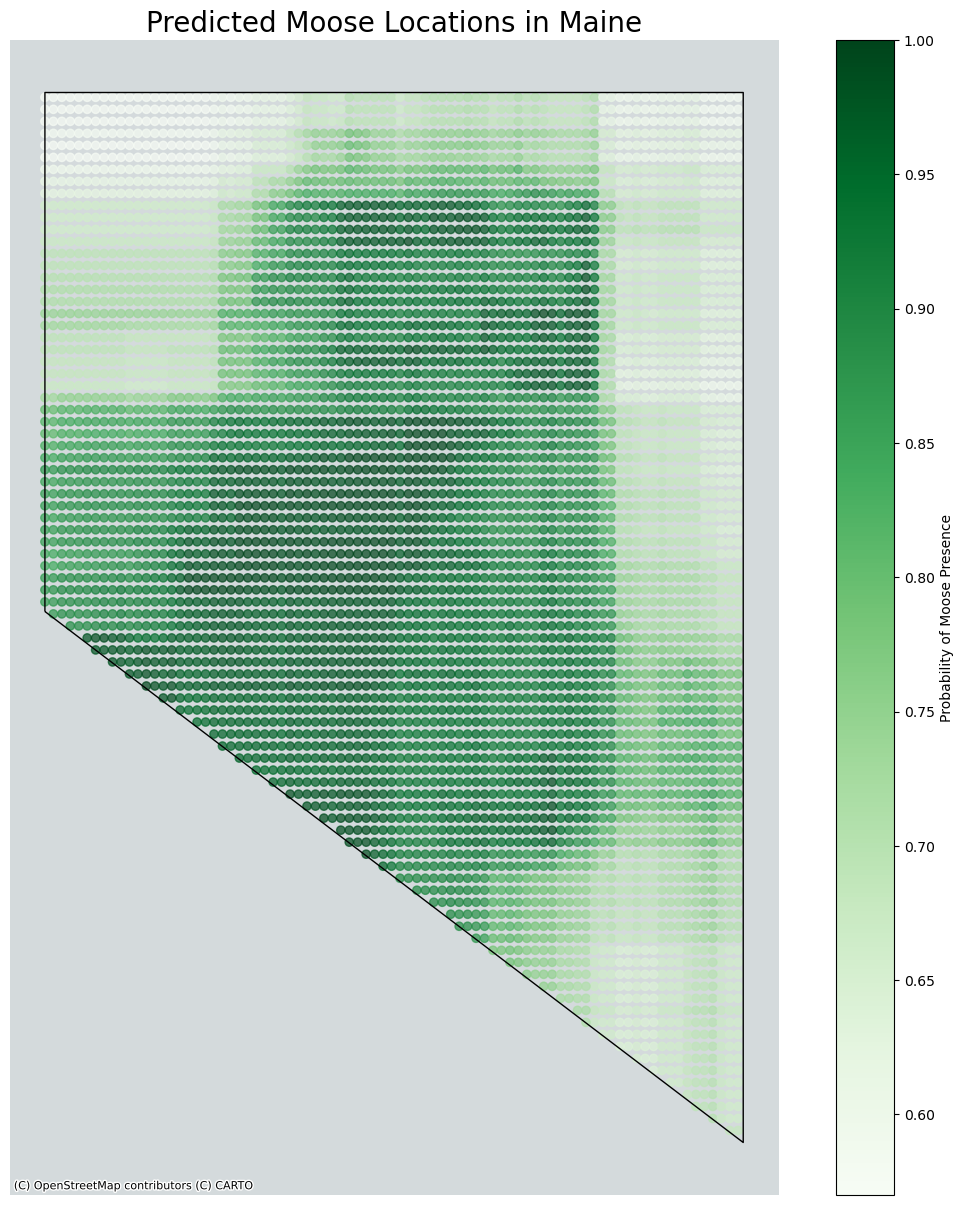

/Users/jessicachace/anaconda3/envs/inat-env/lib/python3.10/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


Comparison map saved as 'moose_prediction_vs_actual_map.png'


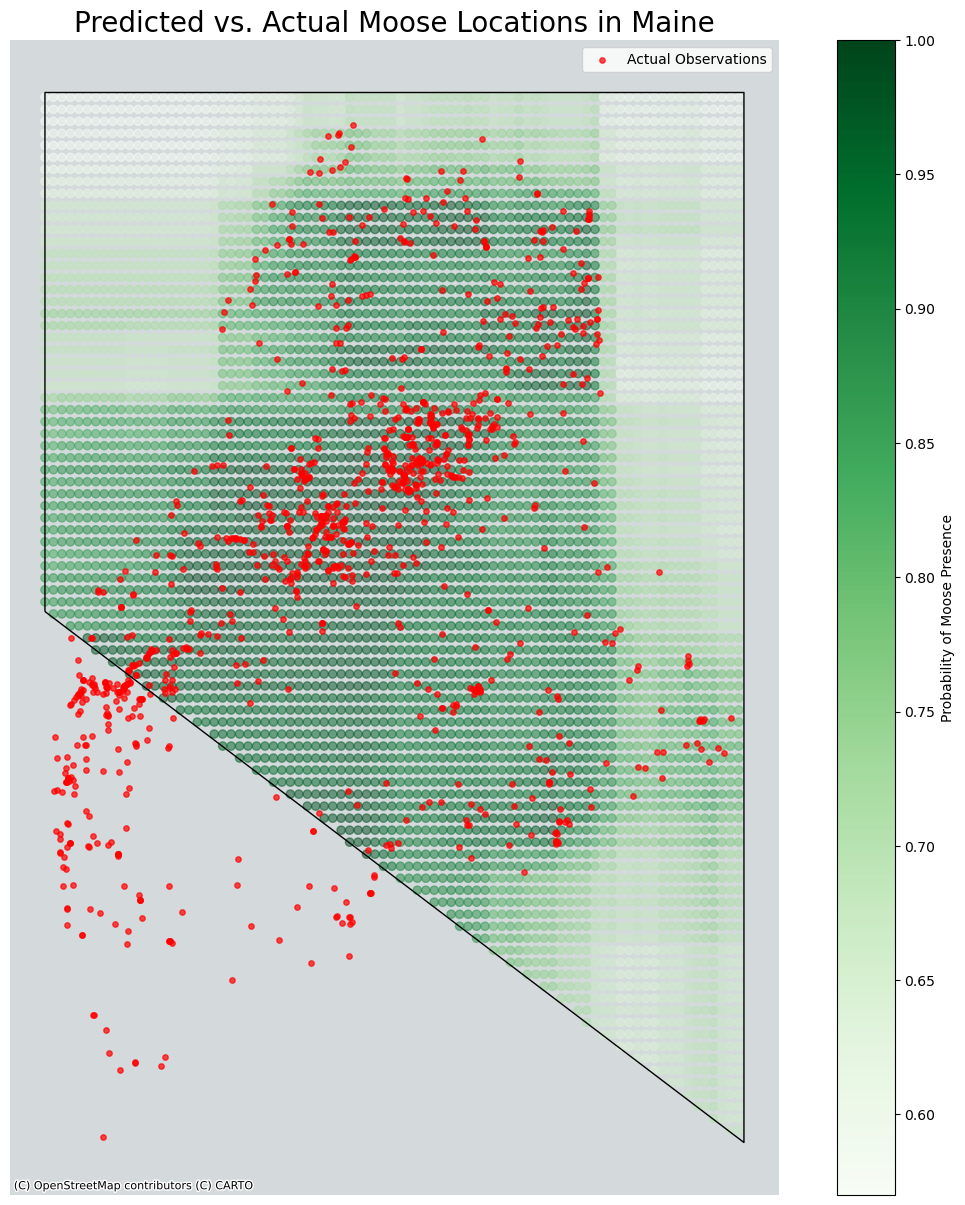

In [4]:
# Building a predictive model for moose locations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import contextily as cx
import ssl
import os

# Create a new cell with title
print("# Predictive Model for Moose Locations in Maine")
print("## 1. Preparing the data")

# First, let's convert our observations dataframe to a GeoDataFrame
try:
    # Check if we have the observations_df from earlier
    if 'observations_df' not in globals():
        print("Loading observations from CSV file...")
        # Define the file path - update this to your actual path
        file_path = "/Users/jessicachace/Downloads/observations-594739.csv/observations-594739.csv"
        observations_df = pd.read_csv(file_path)
    
    print(f"Loaded {len(observations_df)} observations")
    
    # Check if we have latitude and longitude columns
    required_columns = ['latitude', 'longitude']
    if not all(col in observations_df.columns for col in required_columns):
        print("Looking for latitude/longitude columns...")
        # Try to identify potential coordinate columns
        potential_lat_cols = [col for col in observations_df.columns 
                             if 'lat' in col.lower()]
        potential_lon_cols = [col for col in observations_df.columns 
                             if 'lon' in col.lower() or 'lng' in col.lower()]
        
        print(f"Potential latitude columns: {potential_lat_cols}")
        print(f"Potential longitude columns: {potential_lon_cols}")
        
        # If found, use the first one
        if potential_lat_cols and potential_lon_cols:
            lat_col = potential_lat_cols[0]
            lon_col = potential_lon_cols[0]
            print(f"Using {lat_col} and {lon_col} as coordinate columns")
        else:
            raise ValueError("Could not find latitude and longitude columns")
    else:
        lat_col = 'latitude'
        lon_col = 'longitude'
    
    # Convert to GeoDataFrame
    print("Converting to GeoDataFrame...")
    # Remove rows with missing coordinates
    observations_df = observations_df.dropna(subset=[lat_col, lon_col])
    
    # Create geometry column
    geometry = [Point(xy) for xy in zip(observations_df[lon_col], observations_df[lat_col])]
    gdf = gpd.GeoDataFrame(observations_df, geometry=geometry)
    
    # Set coordinate reference system (CRS) to WGS84
    gdf.crs = "EPSG:4326"
    
    print(f"Created GeoDataFrame with {len(gdf)} points")
    
    # Create Maine boundary if not already defined
    if 'maine' not in globals():
        print("Creating simplified Maine boundary...")
        
        # Create a simplified Maine boundary using approximate coordinates
        # These are approximate coordinates for Maine's boundary
        maine_coords = [
            (-71.08, 45.30),  # Southwest corner
            (-71.08, 47.46),  # Northwest corner
            (-66.95, 47.46),  # Northeast corner
            (-66.95, 43.09),  # Southeast corner
            (-71.08, 45.30)   # Close the polygon
        ]
        
        # Create a polygon from the coordinates
        maine_polygon = Polygon(maine_coords)
        
        # Create a GeoDataFrame with the polygon
        maine = gpd.GeoDataFrame(
            {'geometry': [maine_polygon]}, 
            crs="EPSG:4326"
        )
        
        print("Created simplified Maine boundary")
    
    # Function to generate random points within Maine's boundaries
    def generate_random_points_in_maine(n_points, maine_gdf):
        # Get the bounds of Maine
        minx, miny, maxx, maxy = maine_gdf.total_bounds
        
        # Generate random points
        random_points = []
        while len(random_points) < n_points:
            x = np.random.uniform(minx, maxx)
            y = np.random.uniform(miny, maxy)
            point = Point(x, y)
            
            # Check if point is within Maine
            if any(maine_gdf.contains(point)):
                random_points.append(point)
        
        # Create a GeoDataFrame
        random_gdf = gpd.GeoDataFrame(
            {'geometry': random_points, 'observed': 0},
            crs=maine_gdf.crs
        )
        return random_gdf
    
    # Add a column to mark these as actual observations
    gdf['observed'] = 1
    
    # Generate an equal number of random points
    n_observations = len(gdf)
    print(f"Generating {n_observations} random points as negative examples...")
    random_points = generate_random_points_in_maine(n_observations, maine)
    
    # Combine the datasets
    combined_gdf = pd.concat([gdf, random_points])
    
    print(f"Combined dataset has {len(combined_gdf)} points")
    print(f"Positive examples (actual moose observations): {len(gdf)}")
    print(f"Negative examples (random locations): {len(random_points)}")
    
    # Extract features: coordinates and any other available features
    # For now, we'll just use coordinates as features
    combined_gdf['x'] = combined_gdf.geometry.x
    combined_gdf['y'] = combined_gdf.geometry.y
    
    # Check if we have date information
    if 'observed_on' in combined_gdf.columns:
        # Convert to datetime if not already
        combined_gdf['observed_on'] = pd.to_datetime(combined_gdf['observed_on'], errors='coerce')
        
        # Extract month and add as feature
        combined_gdf['month'] = combined_gdf['observed_on'].dt.month
        
        # Extract features list
        features = ['x', 'y', 'month']
        print("Using coordinates and month as features")
    else:
        features = ['x', 'y']
        print("Using only coordinates as features")
    
    # Split into features and target
    X = combined_gdf[features]
    y = combined_gdf['observed']
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("\n## 2. Training the model")
    
    # Train a Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    
    # Evaluate the model
    y_pred = rf.predict(X_test_scaled)
    
    print("\n## 3. Model Evaluation")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
    
    print("\n## 4. Generating Predictions for All of Maine")
    
    # Create a grid of points covering Maine
    grid_size = 0.05  # Adjust based on desired resolution
    x_range = np.arange(maine.total_bounds[0], maine.total_bounds[2], grid_size)
    y_range = np.arange(maine.total_bounds[1], maine.total_bounds[3], grid_size)
    
    # Create meshgrid
    xx, yy = np.meshgrid(x_range, y_range)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # If we're using month as a feature, add the current month
    if 'month' in features:
        current_month = pd.Timestamp.now().month
        grid_month = np.full((grid_points.shape[0], 1), current_month)
        grid_points = np.hstack([grid_points, grid_month])
    
    # Scale the grid points
    grid_points_scaled = scaler.transform(grid_points)
    
    # Predict probability for each point
    grid_pred_proba = rf.predict_proba(grid_points_scaled)[:, 1]
    
    # Create a GeoDataFrame with the predictions
    geometry = [Point(x, y) for x, y in zip(xx.ravel(), yy.ravel())]
    prediction_gdf = gpd.GeoDataFrame(
        {'geometry': geometry, 'probability': grid_pred_proba},
        crs=maine.crs
    )
    
    # Clip to Maine's boundary
    prediction_gdf = gpd.clip(prediction_gdf, maine)
    
    print(f"Generated predictions for {len(prediction_gdf)} points in Maine")
    
    print("\n## 5. Visualizing the Predictions")
    
    # Create a map
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Plot the prediction heatmap
    prediction_gdf.plot(
        column='probability', 
        ax=ax, 
        alpha=0.7, 
        cmap='Greens',
        legend=True,
        legend_kwds={'label': "Probability of Moose Presence"}
    )
    
    # Plot Maine boundary
    maine.boundary.plot(ax=ax, color='black', linewidth=1)
    
    # Add a basemap
    try:
        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Could not add basemap: {e}")
    
    # Add title
    plt.title('Predicted Moose Locations in Maine', fontsize=20)
    
    # Turn off axis
    ax.set_axis_off()
    
    # Save the map
    plt.savefig('moose_prediction_map.png', dpi=300, bbox_inches='tight')
    print("Prediction map saved as 'moose_prediction_map.png'")
    plt.show()
    
    # Create a second map showing both predictions and actual observations
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Plot the prediction heatmap
    prediction_gdf.plot(
        column='probability', 
        ax=ax, 
        alpha=0.5, 
        cmap='Greens',
        legend=True,
        legend_kwds={'label': "Probability of Moose Presence"}
    )
    
    # Plot Maine boundary
    maine.boundary.plot(ax=ax, color='black', linewidth=1)
    
    # Plot actual moose observations
    gdf.plot(ax=ax, color='red', markersize=15, alpha=0.7, label='Actual Observations')
    
    # Add a basemap
    try:
        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Could not add basemap: {e}")
    
    # Add legend
    ax.legend()
    
    # Add title
    plt.title('Predicted vs. Actual Moose Locations in Maine', fontsize=20)
    
    # Turn off axis
    ax.set_axis_off()
    
    # Save the map
    plt.savefig('moose_prediction_vs_actual_map.png', dpi=300, bbox_inches='tight')
    print("Comparison map saved as 'moose_prediction_vs_actual_map.png'")
    plt.show()
    
except Exception as e:
    import traceback
    print(f"Error building predictive model: {e}")
    traceback.print_exc()